# Image Captioning - Team SaaS

### Imports here

In [1]:
# python2 and python3 compatibility between loaded modules
from __future__ import print_function

In [2]:
# All imports go here
%matplotlib notebook

# Reading files
import os

# Vector manipulations
import numpy as np

# DL framework
# torch
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
from torch.nn.utils.rnn import pack_padded_sequence

# Plotting images
from matplotlib import pyplot as plt

# COCO loading captions
from pycocotools.coco import COCO
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# import created vocabulary
from vocab_creator import VocabCreate as vc

# PIL Image
from PIL import Image

# regex for captions
import re

# import nntools
import nntools_modified as nt

# import add for fast addition between lists
from operator import add

from pycocoevalcap.bleu.bleu import Bleu

# json for dumping stuff onto files as output
import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Data Loading Initializations

In [4]:
# data loading
dataset_root_dir = '/datasets/COCO-2015/'
annotations_root_dir = '../datasets/COCO/annotations/'
train_dir = "train2014"
val_dir = "val2014"
test_dir = "test2015"

# output directory for training checkpoints
# This changes for every experiment
op_dir = "../outputs/" + "vgg16_sgd"

In [5]:
# training data annotations
train_ann = "{}captions_{}.json".format(annotations_root_dir, train_dir)
coco_train_caps = COCO(train_ann)

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!


### Dataset Loading

In [6]:
# dataset class
class COCODataset(td.Dataset):
    """Class to load the COCODataset"""
    
    def __init__(self, dataset_root_dir, annotations_root_dir, vocab, mode="train2014", image_size=(224, 224)):
        super(COCODataset, self).__init__()
        self.dataset_root_dir = dataset_root_dir
        self.annotations_root_dir = annotations_root_dir
        self.image_size = image_size
        self.mode = mode
        # training data annotations
        self.ann = "{}captions_{}.json".format(annotations_root_dir, mode)
        self.coco_caps = COCO(self.ann)
        # get all the image IDs
        self.image_ids = self.coco_caps.getImgIds()
        self.ann_ids = list(self.coco_caps.anns.keys())
        # loadImgs() returns all the images
        self.imgs = self.coco_caps.loadImgs(self.image_ids)
        self.vocab = vocab
        
    def __len__(self):
        return len(self.ann_ids)
    
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
        format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        ann_id = self.ann_ids[idx]
        cap = self.coco_caps.anns[ann_id]["caption"]
        img_id = self.coco_caps.anns[ann_id]["image_id"]
        img_path = self.coco_caps.loadImgs(img_id)[0]["file_name"]
        
        img = Image.open('{}/{}/{}'.format(self.dataset_root_dir, self.mode, img_path))
        img = img.convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            #tv.transforms.RandomHorizontalFlip(),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        x = transform(img)
        
        # return caption
        cap = str(cap)
        clean_cap = re.sub(r'[^a-zA-Z0-9 ]+', '', cap)
        word_list = clean_cap.lower().strip().split()
        for i in range(len(word_list)):
            if word_list[i] not in vocab.one_hot_inds:
                word_list[i]="unk_vec"
        d = torch.Tensor([vocab.one_hot_inds["start_vec"]]
                               + [vocab.one_hot_inds[w] for w in word_list]
                               + [vocab.one_hot_inds["end_vec"]]
        )
        return x, d
    

In [7]:
# load the vocabulary
# or Create and save to output
dict_path = "../outputs/vocab.npz"
vocab = vc(train_ann, dict_path)

In [8]:
# create an instance of the cocodataset
training_dataset = COCODataset(dataset_root_dir, annotations_root_dir, vocab)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [9]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image<0] = 0
    image[image>1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [10]:
# defining the dataloader to be used
# collate_fn - to pad all the vectors to the same length
def collate_function(data):
    data.sort(key=lambda x:len(x[1]), reverse=True)
    img, cap=zip(*data)

    #stack images
    img = torch.stack(img, 0)

    #concatenate all captions
    cap_lens = [len(c) for c in cap]
    max_cap_lens = max(cap_lens)
    cap_lens = torch.Tensor(cap_lens)

    #pad all captions to max caption length
    padded_caption = torch.zeros(len(cap),max_cap_lens).long()
    for i, c in enumerate(cap):
        c_len = int(cap_lens[i].item())
        padded_caption[i,:c_len] = c[:c_len]

    return img, padded_caption, cap_lens

In [11]:
train_loader = td.DataLoader(training_dataset, batch_size=128, shuffle=True, pin_memory=True,
                             collate_fn=collate_function, worker_init_fn=torch.manual_seed(7))

In [12]:
# index to caption
def index_to_cap(labs):
    """Index to caption"""
    cap = labs.cpu().data.numpy().astype(int)
    caps = [vocab.dict[cap[c]] for c in range(len(cap))]
    #caps = caps[1:-1]
    caps = list(filter(lambda a: a != "start_vec", caps))
    caps = list(filter(lambda a: a != "end_vec", caps))
    caption = " ".join(caps)
    return caption

In [13]:
# validation dataset
val_dataset = COCODataset(dataset_root_dir, annotations_root_dir, vocab, mode=val_dir)

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [14]:
val_loader = td.DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True, collate_fn=collate_function)

In [15]:
# NN classifier from nntools
class NNClassifier(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [16]:
class CNN_RNN(NNClassifier):
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1,
                 num_classes=512, fine_tuning=False):
        super(CNN_RNN, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        # the average pooling is the same
        self.avgpool = vgg.avgpool
        # the classifier is also the same
        self.classifier = vgg.classifier
        # CODE to change the final classifier layer
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        # RNN Part
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.unit = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, caps, lens):
        # COMPLETE the forward prop
        f = self.features(x)
        f = self.avgpool(f)
        f = torch.flatten(f, 1)
        f = self.classifier(f)
        
        # RNN forward prop
        embeddings = self.embeddings(caps)
        inputs = torch.cat((f.unsqueeze(1), embeddings), 1)
        packed_ip = pack_padded_sequence(inputs, lens, batch_first=True)
        
        h_state, _ = self.unit(packed_ip)
        outputs = self.linear(h_state[0])
        return outputs
    
    def greedy_sample(self, feats, max_len=30):
        output_ids = []
        states = None
        inputs = feats.unsqueeze(1)

        for i in range(max_len):
            
            h_state, states = self.unit(inputs, states)
            outputs = self.linear(h_state.squeeze(1))
            predicted = outputs.max(1)[1]
            output_ids.append(predicted)
            inputs = self.embeddings(predicted)
            inputs = inputs.unsqueeze(1)
            
        output_ids = torch.stack(output_ids, 1)
        return output_ids.squeeze()

In [17]:
class CaptionStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(CaptionStatsManager, self).__init__()
        
    def init(self):
        super(CaptionStatsManager, self).init()
        self.tokenized_true = {}
        self.tokenized_pred = {}
        self.scorer = Bleu(4)
        self.running_bleu_scores = [0 for _ in range(4)]
        
    def accumulate(self, loss, x, y, d):
        super(CaptionStatsManager, self).accumulate(loss, x, y, d)        
        self.tokenized_true[0] = []
        self.tokenized_pred[0] = []
        _, pred_cap_lab = torch.max(y, 1)
        true_cap_lab = d
        pred_cap = index_to_cap(pred_cap_lab)
        true_cap = index_to_cap(true_cap_lab)
        self.tokenized_true[0].append(true_cap)
        self.tokenized_pred[0].append(pred_cap)
        bleu_scores, _ = self.scorer.compute_score(self.tokenized_true, self.tokenized_pred)
        self.running_bleu_scores = list(map(add, self.running_bleu_scores, bleu_scores))
        
        
    def summarize(self):
        # this is the average loss when called
        loss = super(CaptionStatsManager, self).summarize()
        
        # this is the average accuracy percentage when called
        bleu_score = [ a / self.number_update for a in self.running_bleu_scores]
        return {'loss' : loss, 'bleu' : bleu_score}

In [18]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()

    # Plot the training loss over the epochs
    axes[0].plot([exp.history[k]['loss'] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training loss")

    # legend for the plot
    axes[0].legend()
    
    # xlabel and ylabel
    axes[0].set_xlabel("Number of Mini-batches")
    axes[0].set_ylabel("Loss")
    
    # Plot the training accuracy over the epochs
    axes[1].plot([exp.history[k]['bleu'][0] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-1")
    axes[1].plot([exp.history[k]['bleu'][1] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-2")
    axes[1].plot([exp.history[k]['bleu'][2] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-3")
    axes[1].plot([exp.history[k]['bleu'][3] for k in range((exp.epoch[0] + 1)*(exp.epoch[1]))],
                label="training BLEU-4")
    
    # legend for the plot
    axes[1].legend()
    
    # xlabel and ylabel
    axes[1].set_xlabel("Number of Mini-batches")
    axes[1].set_ylabel("BLEU Scores")
    
    plt.tight_layout()
    fig.canvas.draw()

In [19]:
lr = 1e-3
net = CNN_RNN(embed_size=512, hidden_size=512, vocab_size=len(vocab),
              num_layers=1, num_classes=512, fine_tuning=False)
net = net.to(device)
#adam = torch.optim.Adam(net.parameters(), lr=lr)
#nest_gd = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True)
gd = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
stats_manager = CaptionStatsManager()
exp1 = nt.Experiment(net, training_dataset, val_dataset, gd,
                     stats_manager, collate_func=collate_function, output_dir=op_dir)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 80.7MB/s] 


<IPython.core.display.Javascript object>


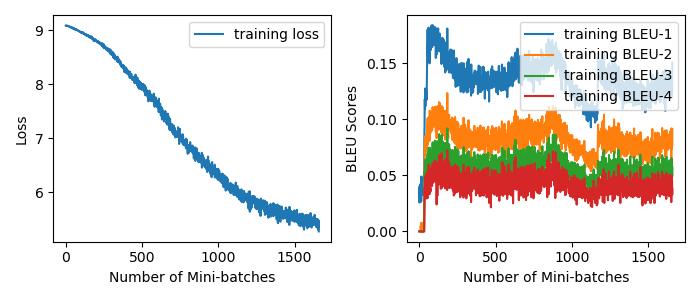

Start/Continue training from epoch 0
Epoch: 0  Batch: 0
{'testlen': 1585, 'reflen': 1329, 'guess': [1585, 1584, 1583, 1582], 'correct': [61, 0, 0, 0]}
ratio: 1.1926260346115931
Epoch: 0  Batch: 1
{'testlen': 1555, 'reflen': 1299, 'guess': [1555, 1554, 1553, 1552], 'correct': [40, 0, 0, 0]}
ratio: 1.1970746728243287
Epoch: 0  Batch: 2
{'testlen': 1613, 'reflen': 1357, 'guess': [1613, 1612, 1611, 1610], 'correct': [65, 0, 0, 0]}
ratio: 1.1886514369924919
Epoch: 0  Batch: 3
{'testlen': 1566, 'reflen': 1310, 'guess': [1566, 1565, 1564, 1563], 'correct': [59, 0, 0, 0]}
ratio: 1.1954198473273316
Epoch: 0  Batch: 4
{'testlen': 1580, 'reflen': 1324, 'guess': [1580, 1579, 1578, 1577], 'correct': [65, 0, 0, 0]}
ratio: 1.1933534743193404
Epoch: 0  Batch: 5
{'testlen': 1555, 'reflen': 1299, 'guess': [1555, 1554, 1553, 1552], 'correct': [54, 0, 0, 0]}
ratio: 1.1970746728243287
Epoch: 0  Batch: 6
{'testlen': 1607, 'reflen': 1351, 'guess': [1607, 1606, 1605, 1604], 'correct': [62, 0, 0, 0]}
ratio: 1.

Epoch: 0  Batch: 58
{'testlen': 1547, 'reflen': 1309, 'guess': [1547, 1546, 1545, 1544], 'correct': [261, 88, 52, 39]}
ratio: 1.181818181817279
Epoch: 0  Batch: 59
{'testlen': 1553, 'reflen': 1313, 'guess': [1553, 1552, 1551, 1550], 'correct': [260, 89, 54, 36]}
ratio: 1.182787509519282
Epoch: 0  Batch: 60
{'testlen': 1567, 'reflen': 1333, 'guess': [1567, 1566, 1565, 1564], 'correct': [285, 89, 53, 37]}
ratio: 1.175543885970611
Epoch: 0  Batch: 61
{'testlen': 1596, 'reflen': 1357, 'guess': [1596, 1595, 1594, 1593], 'correct': [275, 96, 64, 48]}
ratio: 1.17612380250466
Epoch: 0  Batch: 62
{'testlen': 1565, 'reflen': 1325, 'guess': [1565, 1564, 1563, 1562], 'correct': [277, 76, 41, 23]}
ratio: 1.1811320754708068
Epoch: 0  Batch: 63
{'testlen': 1597, 'reflen': 1361, 'guess': [1597, 1596, 1595, 1594], 'correct': [288, 76, 40, 25]}
ratio: 1.1734019103591673
Epoch: 0  Batch: 64
{'testlen': 1611, 'reflen': 1373, 'guess': [1611, 1610, 1609, 1608], 'correct': [282, 92, 53, 35]}
ratio: 1.1733430

Epoch: 0  Batch: 115
{'testlen': 1431, 'reflen': 1315, 'guess': [1431, 1430, 1429, 1428], 'correct': [253, 99, 52, 33]}
ratio: 1.0882129277558266
Epoch: 0  Batch: 116
{'testlen': 1424, 'reflen': 1313, 'guess': [1424, 1423, 1422, 1421], 'correct': [239, 83, 44, 25]}
ratio: 1.0845392231522586
Epoch: 0  Batch: 117
{'testlen': 1405, 'reflen': 1286, 'guess': [1405, 1404, 1403, 1402], 'correct': [239, 101, 60, 38]}
ratio: 1.0925349922231007
Epoch: 0  Batch: 118
{'testlen': 1490, 'reflen': 1359, 'guess': [1490, 1489, 1488, 1487], 'correct': [242, 74, 28, 10]}
ratio: 1.096394407651879
Epoch: 0  Batch: 119
{'testlen': 1485, 'reflen': 1366, 'guess': [1485, 1484, 1483, 1482], 'correct': [250, 97, 65, 46]}
ratio: 1.0871156661778278
Epoch: 0  Batch: 120
{'testlen': 1441, 'reflen': 1340, 'guess': [1441, 1440, 1439, 1438], 'correct': [252, 103, 51, 29]}
ratio: 1.0753731343275557
Epoch: 0  Batch: 121
{'testlen': 1470, 'reflen': 1364, 'guess': [1470, 1469, 1468, 1467], 'correct': [250, 94, 54, 34]}
rat

Epoch: 0  Batch: 172
{'testlen': 1466, 'reflen': 1391, 'guess': [1466, 1465, 1464, 1463], 'correct': [221, 79, 39, 20]}
ratio: 1.0539180445714926
Epoch: 0  Batch: 173
{'testlen': 1404, 'reflen': 1321, 'guess': [1404, 1403, 1402, 1401], 'correct': [217, 78, 43, 22]}
ratio: 1.0628311884927608
Epoch: 0  Batch: 174
{'testlen': 1444, 'reflen': 1353, 'guess': [1444, 1443, 1442, 1441], 'correct': [223, 91, 56, 36]}
ratio: 1.067257945305937
Epoch: 0  Batch: 175
{'testlen': 1395, 'reflen': 1313, 'guess': [1395, 1394, 1393, 1392], 'correct': [229, 93, 44, 24]}
ratio: 1.0624523990852532
Epoch: 0  Batch: 176
{'testlen': 1402, 'reflen': 1324, 'guess': [1402, 1401, 1400, 1399], 'correct': [216, 91, 49, 29]}
ratio: 1.058912386706149
Epoch: 0  Batch: 177
{'testlen': 1357, 'reflen': 1283, 'guess': [1357, 1356, 1355, 1354], 'correct': [195, 67, 38, 21]}
ratio: 1.0576773187832753
Epoch: 0  Batch: 178
{'testlen': 1452, 'reflen': 1358, 'guess': [1452, 1451, 1450, 1449], 'correct': [233, 97, 54, 32]}
ratio:

Epoch: 0  Batch: 229
{'testlen': 1387, 'reflen': 1283, 'guess': [1387, 1386, 1385, 1384], 'correct': [196, 62, 26, 14]}
ratio: 1.081060015587622
Epoch: 0  Batch: 230
{'testlen': 1485, 'reflen': 1373, 'guess': [1485, 1484, 1483, 1482], 'correct': [214, 68, 37, 22]}
ratio: 1.0815731973772167
Epoch: 0  Batch: 231
{'testlen': 1436, 'reflen': 1311, 'guess': [1436, 1435, 1434, 1433], 'correct': [195, 72, 38, 20]}
ratio: 1.0953470633096145
Epoch: 0  Batch: 232
{'testlen': 1457, 'reflen': 1337, 'guess': [1457, 1456, 1455, 1454], 'correct': [215, 86, 53, 36]}
ratio: 1.0897531787575994
Epoch: 0  Batch: 233
{'testlen': 1463, 'reflen': 1317, 'guess': [1463, 1462, 1461, 1460], 'correct': [213, 86, 45, 28]}
ratio: 1.1108580106293768
Epoch: 0  Batch: 234
{'testlen': 1507, 'reflen': 1371, 'guess': [1507, 1506, 1505, 1504], 'correct': [232, 102, 62, 44]}
ratio: 1.0991976659364704
Epoch: 0  Batch: 235
{'testlen': 1478, 'reflen': 1336, 'guess': [1478, 1477, 1476, 1475], 'correct': [212, 81, 45, 27]}
rati

Epoch: 0  Batch: 286
{'testlen': 1538, 'reflen': 1343, 'guess': [1538, 1537, 1536, 1535], 'correct': [202, 69, 39, 24]}
ratio: 1.14519731943325
Epoch: 0  Batch: 287
{'testlen': 1546, 'reflen': 1346, 'guess': [1546, 1545, 1544, 1543], 'correct': [209, 74, 38, 22]}
ratio: 1.1485884101031585
Epoch: 0  Batch: 288
{'testlen': 1499, 'reflen': 1296, 'guess': [1499, 1498, 1497, 1496], 'correct': [202, 74, 42, 27]}
ratio: 1.1566358024682433
Epoch: 0  Batch: 289
{'testlen': 1572, 'reflen': 1372, 'guess': [1572, 1571, 1570, 1569], 'correct': [195, 60, 31, 14]}
ratio: 1.1457725947513515
Epoch: 0  Batch: 290
{'testlen': 1547, 'reflen': 1368, 'guess': [1547, 1546, 1545, 1544], 'correct': [232, 106, 64, 45]}
ratio: 1.1308479532155475
Epoch: 0  Batch: 291
{'testlen': 1509, 'reflen': 1306, 'guess': [1509, 1508, 1507, 1506], 'correct': [209, 77, 48, 35]}
ratio: 1.1554364471660372
Epoch: 0  Batch: 292
{'testlen': 1557, 'reflen': 1361, 'guess': [1557, 1556, 1555, 1554], 'correct': [212, 76, 43, 26]}
ratio

Epoch: 0  Batch: 343
{'testlen': 1512, 'reflen': 1283, 'guess': [1512, 1511, 1510, 1509], 'correct': [200, 90, 55, 38]}
ratio: 1.1784879189390658
Epoch: 0  Batch: 344
{'testlen': 1520, 'reflen': 1297, 'guess': [1520, 1519, 1518, 1517], 'correct': [204, 72, 37, 21]}
ratio: 1.1719352351571535
Epoch: 0  Batch: 345
{'testlen': 1552, 'reflen': 1336, 'guess': [1552, 1551, 1550, 1549], 'correct': [192, 67, 37, 21]}
ratio: 1.1616766467057174
Epoch: 0  Batch: 346
{'testlen': 1578, 'reflen': 1358, 'guess': [1578, 1577, 1576, 1575], 'correct': [220, 86, 46, 30]}
ratio: 1.1620029455072445
Epoch: 0  Batch: 347
{'testlen': 1596, 'reflen': 1373, 'guess': [1596, 1595, 1594, 1593], 'correct': [223, 70, 36, 21]}
ratio: 1.1624180626357157
Epoch: 0  Batch: 348
{'testlen': 1568, 'reflen': 1353, 'guess': [1568, 1567, 1566, 1565], 'correct': [201, 68, 41, 26]}
ratio: 1.158906134515034
Epoch: 0  Batch: 349
{'testlen': 1548, 'reflen': 1327, 'guess': [1548, 1547, 1546, 1545], 'correct': [200, 74, 41, 26]}
ratio

Epoch: 0  Batch: 400
{'testlen': 1614, 'reflen': 1379, 'guess': [1614, 1613, 1612, 1611], 'correct': [237, 98, 57, 40]}
ratio: 1.1704133430013268
Epoch: 0  Batch: 401
{'testlen': 1587, 'reflen': 1351, 'guess': [1587, 1586, 1585, 1584], 'correct': [218, 78, 43, 24]}
ratio: 1.1746854182078648
Epoch: 0  Batch: 402
{'testlen': 1621, 'reflen': 1388, 'guess': [1621, 1620, 1619, 1618], 'correct': [218, 91, 56, 39]}
ratio: 1.1678674351576601
Epoch: 0  Batch: 403
{'testlen': 1589, 'reflen': 1360, 'guess': [1589, 1588, 1587, 1586], 'correct': [213, 74, 41, 23]}
ratio: 1.1683823529403174
Epoch: 0  Batch: 404
{'testlen': 1573, 'reflen': 1343, 'guess': [1573, 1572, 1571, 1570], 'correct': [218, 84, 54, 44]}
ratio: 1.1712583767675568
Epoch: 0  Batch: 405
{'testlen': 1596, 'reflen': 1373, 'guess': [1596, 1595, 1594, 1593], 'correct': [199, 79, 41, 25]}
ratio: 1.1624180626357157
Epoch: 0  Batch: 406
{'testlen': 1570, 'reflen': 1327, 'guess': [1570, 1569, 1568, 1567], 'correct': [201, 67, 35, 20]}
rati

Epoch: 0  Batch: 457
{'testlen': 1536, 'reflen': 1290, 'guess': [1536, 1535, 1534, 1533], 'correct': [178, 57, 23, 10]}
ratio: 1.1906976744176816
Epoch: 0  Batch: 458
{'testlen': 1602, 'reflen': 1364, 'guess': [1602, 1601, 1600, 1599], 'correct': [218, 82, 50, 31]}
ratio: 1.1744868035182006
Epoch: 0  Batch: 459
{'testlen': 1590, 'reflen': 1349, 'guess': [1590, 1589, 1588, 1587], 'correct': [218, 84, 48, 32]}
ratio: 1.1786508524824473
Epoch: 0  Batch: 460
{'testlen': 1632, 'reflen': 1393, 'guess': [1632, 1631, 1630, 1629], 'correct': [221, 75, 39, 24]}
ratio: 1.1715721464456772
Epoch: 0  Batch: 461
{'testlen': 1590, 'reflen': 1346, 'guess': [1590, 1589, 1588, 1587], 'correct': [208, 59, 29, 18]}
ratio: 1.1812778603260168
Epoch: 0  Batch: 462
{'testlen': 1527, 'reflen': 1288, 'guess': [1527, 1526, 1525, 1524], 'correct': [200, 78, 42, 24]}
ratio: 1.1855590062102597
Epoch: 0  Batch: 463
{'testlen': 1620, 'reflen': 1387, 'guess': [1620, 1619, 1618, 1617], 'correct': [223, 75, 41, 28]}
rati

Epoch: 0  Batch: 514
{'testlen': 1607, 'reflen': 1365, 'guess': [1607, 1606, 1605, 1604], 'correct': [209, 67, 42, 29]}
ratio: 1.177289377288515
Epoch: 0  Batch: 515
{'testlen': 1626, 'reflen': 1379, 'guess': [1626, 1625, 1624, 1623], 'correct': [199, 77, 41, 30]}
ratio: 1.1791153009418571
Epoch: 0  Batch: 516
{'testlen': 1617, 'reflen': 1373, 'guess': [1617, 1616, 1615, 1614], 'correct': [204, 63, 34, 24]}
ratio: 1.1777130371440803
Epoch: 0  Batch: 517
{'testlen': 1567, 'reflen': 1320, 'guess': [1567, 1566, 1565, 1564], 'correct': [224, 79, 44, 27]}
ratio: 1.1871212121203127
Epoch: 0  Batch: 518
{'testlen': 1572, 'reflen': 1320, 'guess': [1572, 1571, 1570, 1569], 'correct': [208, 70, 39, 24]}
ratio: 1.1909090909081887
Epoch: 0  Batch: 519
{'testlen': 1641, 'reflen': 1404, 'guess': [1641, 1640, 1639, 1638], 'correct': [227, 83, 46, 32]}
ratio: 1.1688034188025864
Epoch: 0  Batch: 520
{'testlen': 1592, 'reflen': 1347, 'guess': [1592, 1591, 1590, 1589], 'correct': [206, 88, 54, 40]}
ratio

Epoch: 0  Batch: 571
{'testlen': 1577, 'reflen': 1335, 'guess': [1577, 1576, 1575, 1574], 'correct': [211, 77, 44, 30]}
ratio: 1.1812734082388154
Epoch: 0  Batch: 572
{'testlen': 1543, 'reflen': 1306, 'guess': [1543, 1542, 1541, 1540], 'correct': [208, 85, 50, 30]}
ratio: 1.1814701378245165
Epoch: 0  Batch: 573
{'testlen': 1612, 'reflen': 1375, 'guess': [1612, 1611, 1610, 1609], 'correct': [225, 86, 45, 30]}
ratio: 1.1723636363627838
Epoch: 0  Batch: 574
{'testlen': 1613, 'reflen': 1372, 'guess': [1613, 1612, 1611, 1610], 'correct': [226, 87, 53, 40]}
ratio: 1.175655976675528
Epoch: 0  Batch: 575
{'testlen': 1562, 'reflen': 1335, 'guess': [1562, 1561, 1560, 1559], 'correct': [202, 59, 25, 14]}
ratio: 1.170037453182644
Epoch: 0  Batch: 576
{'testlen': 1569, 'reflen': 1334, 'guess': [1569, 1568, 1567, 1566], 'correct': [188, 61, 31, 19]}
ratio: 1.176161919039598
Epoch: 0  Batch: 577
{'testlen': 1644, 'reflen': 1407, 'guess': [1644, 1643, 1642, 1641], 'correct': [205, 59, 33, 20]}
ratio: 

Epoch: 0  Batch: 628
{'testlen': 1455, 'reflen': 1329, 'guess': [1455, 1454, 1453, 1452], 'correct': [206, 87, 55, 39]}
ratio: 1.0948081264100114
Epoch: 0  Batch: 629
{'testlen': 1499, 'reflen': 1371, 'guess': [1499, 1498, 1497, 1496], 'correct': [218, 74, 37, 23]}
ratio: 1.093362509116635
Epoch: 0  Batch: 630
{'testlen': 1428, 'reflen': 1302, 'guess': [1428, 1427, 1426, 1425], 'correct': [228, 104, 67, 50]}
ratio: 1.0967741935475448
Epoch: 0  Batch: 631
{'testlen': 1454, 'reflen': 1328, 'guess': [1454, 1453, 1452, 1451], 'correct': [203, 73, 47, 33]}
ratio: 1.0948795180714648
Epoch: 0  Batch: 632
{'testlen': 1443, 'reflen': 1320, 'guess': [1443, 1442, 1441, 1440], 'correct': [196, 70, 36, 20]}
ratio: 1.09318181818099
Epoch: 0  Batch: 633
{'testlen': 1433, 'reflen': 1306, 'guess': [1433, 1432, 1431, 1430], 'correct': [207, 68, 35, 17]}
ratio: 1.0972434915764953
Epoch: 0  Batch: 634
{'testlen': 1447, 'reflen': 1321, 'guess': [1447, 1446, 1445, 1444], 'correct': [220, 81, 45, 27]}
ratio:

Epoch: 0  Batch: 685
{'testlen': 1501, 'reflen': 1373, 'guess': [1501, 1500, 1499, 1498], 'correct': [211, 76, 42, 26]}
ratio: 1.0932265112883517
Epoch: 0  Batch: 686
{'testlen': 1433, 'reflen': 1309, 'guess': [1433, 1432, 1431, 1430], 'correct': [212, 82, 45, 35]}
ratio: 1.0947288006103173
Epoch: 0  Batch: 687
{'testlen': 1480, 'reflen': 1356, 'guess': [1480, 1479, 1478, 1477], 'correct': [219, 88, 51, 34]}
ratio: 1.0914454277278087
Epoch: 0  Batch: 688
{'testlen': 1461, 'reflen': 1335, 'guess': [1461, 1460, 1459, 1458], 'correct': [218, 87, 54, 37]}
ratio: 1.0943820224710903
Epoch: 0  Batch: 689
{'testlen': 1449, 'reflen': 1326, 'guess': [1449, 1448, 1447, 1446], 'correct': [218, 91, 49, 32]}
ratio: 1.092760180994651
Epoch: 0  Batch: 690
{'testlen': 1429, 'reflen': 1303, 'guess': [1429, 1428, 1427, 1426], 'correct': [205, 79, 44, 29]}
ratio: 1.0966999232531875
Epoch: 0  Batch: 691
{'testlen': 1533, 'reflen': 1410, 'guess': [1533, 1532, 1531, 1530], 'correct': [236, 91, 49, 29]}
ratio

Epoch: 0  Batch: 742
{'testlen': 1467, 'reflen': 1340, 'guess': [1467, 1466, 1465, 1464], 'correct': [202, 78, 46, 32]}
ratio: 1.0947761194021681
Epoch: 0  Batch: 743
{'testlen': 1445, 'reflen': 1318, 'guess': [1445, 1444, 1443, 1442], 'correct': [225, 80, 44, 25]}
ratio: 1.0963581183603215
Epoch: 0  Batch: 744
{'testlen': 1451, 'reflen': 1330, 'guess': [1451, 1450, 1449, 1448], 'correct': [209, 82, 45, 29]}
ratio: 1.0909774436082023
Epoch: 0  Batch: 745
{'testlen': 1453, 'reflen': 1327, 'guess': [1453, 1452, 1451, 1450], 'correct': [213, 86, 52, 36]}
ratio: 1.0949510173315034
Epoch: 0  Batch: 746
{'testlen': 1482, 'reflen': 1357, 'guess': [1482, 1481, 1480, 1479], 'correct': [218, 76, 36, 22]}
ratio: 1.092114959468613
Epoch: 0  Batch: 747
{'testlen': 1492, 'reflen': 1373, 'guess': [1492, 1491, 1490, 1489], 'correct': [221, 82, 44, 29]}
ratio: 1.0866715222133383
Epoch: 0  Batch: 748
{'testlen': 1488, 'reflen': 1364, 'guess': [1488, 1487, 1486, 1485], 'correct': [185, 53, 27, 14]}
ratio

Epoch: 0  Batch: 799
{'testlen': 1435, 'reflen': 1326, 'guess': [1435, 1434, 1433, 1432], 'correct': [233, 88, 49, 33]}
ratio: 1.0822021116130602
Epoch: 0  Batch: 800
{'testlen': 1426, 'reflen': 1328, 'guess': [1426, 1425, 1424, 1423], 'correct': [209, 78, 50, 33]}
ratio: 1.073795180722083
Epoch: 0  Batch: 801
{'testlen': 1452, 'reflen': 1349, 'guess': [1452, 1451, 1450, 1449], 'correct': [212, 85, 47, 27]}
ratio: 1.0763528539651028
Epoch: 0  Batch: 802
{'testlen': 1439, 'reflen': 1340, 'guess': [1439, 1438, 1437, 1436], 'correct': [221, 86, 47, 32]}
ratio: 1.073880597014124
Epoch: 0  Batch: 803
{'testlen': 1449, 'reflen': 1354, 'guess': [1449, 1448, 1447, 1446], 'correct': [232, 89, 53, 38]}
ratio: 1.0701624815353987
Epoch: 0  Batch: 804
{'testlen': 1457, 'reflen': 1353, 'guess': [1457, 1456, 1455, 1454], 'correct': [220, 89, 53, 36]}
ratio: 1.0768662232068906
Epoch: 0  Batch: 805
{'testlen': 1443, 'reflen': 1338, 'guess': [1443, 1442, 1441, 1440], 'correct': [231, 89, 48, 29]}
ratio:

Epoch: 0  Batch: 856
{'testlen': 1343, 'reflen': 1363, 'guess': [1343, 1342, 1341, 1340], 'correct': [211, 80, 44, 28]}
ratio: 0.9853264856926006
Epoch: 0  Batch: 857
{'testlen': 1358, 'reflen': 1376, 'guess': [1358, 1357, 1356, 1355], 'correct': [210, 81, 45, 32]}
ratio: 0.9869186046504456
Epoch: 0  Batch: 858
{'testlen': 1315, 'reflen': 1354, 'guess': [1315, 1314, 1313, 1312], 'correct': [215, 86, 54, 34]}
ratio: 0.9711964549475841
Epoch: 0  Batch: 859
{'testlen': 1301, 'reflen': 1342, 'guess': [1301, 1300, 1299, 1298], 'correct': [214, 92, 57, 39]}
ratio: 0.9694485842019602
Epoch: 0  Batch: 860
{'testlen': 1275, 'reflen': 1318, 'guess': [1275, 1274, 1273, 1272], 'correct': [221, 89, 49, 30]}
ratio: 0.9673748103179307
Epoch: 0  Batch: 861
{'testlen': 1308, 'reflen': 1337, 'guess': [1308, 1307, 1306, 1305], 'correct': [207, 76, 37, 14]}
ratio: 0.9783096484659848
Epoch: 0  Batch: 862
{'testlen': 1318, 'reflen': 1349, 'guess': [1318, 1317, 1316, 1315], 'correct': [209, 77, 42, 29]}
rati

{'testlen': 1024, 'reflen': 1354, 'guess': [1024, 1023, 1022, 1021], 'correct': [228, 95, 60, 45]}
ratio: 0.7562776957158374
Epoch: 0  Batch: 913
{'testlen': 1039, 'reflen': 1364, 'guess': [1039, 1038, 1037, 1036], 'correct': [216, 79, 46, 27]}
ratio: 0.7617302052780339
Epoch: 0  Batch: 914
{'testlen': 1058, 'reflen': 1337, 'guess': [1058, 1057, 1056, 1055], 'correct': [204, 77, 46, 35]}
ratio: 0.7913238593860947
Epoch: 0  Batch: 915
{'testlen': 981, 'reflen': 1298, 'guess': [981, 980, 979, 978], 'correct': [210, 80, 40, 22]}
ratio: 0.7557781201843176
Epoch: 0  Batch: 916
{'testlen': 1019, 'reflen': 1346, 'guess': [1019, 1018, 1017, 1016], 'correct': [208, 90, 48, 35]}
ratio: 0.7570579494793781
Epoch: 0  Batch: 917
{'testlen': 1004, 'reflen': 1357, 'guess': [1004, 1003, 1002, 1001], 'correct': [217, 82, 46, 31]}
ratio: 0.7398673544578188
Epoch: 0  Batch: 918
{'testlen': 983, 'reflen': 1342, 'guess': [983, 982, 981, 980], 'correct': [221, 81, 45, 30]}
ratio: 0.7324888226522113
Epoch: 0 

{'testlen': 807, 'reflen': 1316, 'guess': [807, 806, 805, 804], 'correct': [216, 82, 48, 31]}
ratio: 0.6132218844980143
Epoch: 0  Batch: 971
{'testlen': 769, 'reflen': 1323, 'guess': [769, 768, 767, 766], 'correct': [209, 78, 45, 31]}
ratio: 0.5812547241114276
Epoch: 0  Batch: 972
{'testlen': 813, 'reflen': 1349, 'guess': [813, 812, 811, 810], 'correct': [215, 77, 43, 24]}
ratio: 0.6026686434391382
Epoch: 0  Batch: 973
{'testlen': 802, 'reflen': 1315, 'guess': [802, 801, 800, 799], 'correct': [207, 84, 49, 34]}
ratio: 0.6098859315584716
Epoch: 0  Batch: 974
{'testlen': 807, 'reflen': 1315, 'guess': [807, 806, 805, 804], 'correct': [198, 79, 52, 36]}
ratio: 0.6136882129272899
Epoch: 0  Batch: 975
{'testlen': 802, 'reflen': 1337, 'guess': [802, 801, 800, 799], 'correct': [214, 88, 50, 39]}
ratio: 0.5998504113682873
Epoch: 0  Batch: 976
{'testlen': 833, 'reflen': 1370, 'guess': [833, 832, 831, 830], 'correct': [212, 75, 38, 26]}
ratio: 0.6080291970798481
Epoch: 0  Batch: 977
{'testlen': 7

{'testlen': 674, 'reflen': 1332, 'guess': [674, 673, 672, 671], 'correct': [214, 94, 58, 41]}
ratio: 0.5060060060056262
Epoch: 0  Batch: 1029
{'testlen': 678, 'reflen': 1316, 'guess': [678, 677, 676, 675], 'correct': [202, 84, 49, 30]}
ratio: 0.5151975683886663
Epoch: 0  Batch: 1030
{'testlen': 685, 'reflen': 1294, 'guess': [685, 684, 683, 682], 'correct': [208, 76, 42, 27]}
ratio: 0.5293663060274116
Epoch: 0  Batch: 1031
{'testlen': 675, 'reflen': 1348, 'guess': [675, 674, 673, 672], 'correct': [206, 64, 25, 11]}
ratio: 0.5007418397622398
Epoch: 0  Batch: 1032
{'testlen': 692, 'reflen': 1335, 'guess': [692, 691, 690, 689], 'correct': [228, 91, 47, 32]}
ratio: 0.5183520599247053
Epoch: 0  Batch: 1033
{'testlen': 644, 'reflen': 1356, 'guess': [644, 643, 642, 641], 'correct': [231, 83, 47, 30]}
ratio: 0.4749262536869654
Epoch: 0  Batch: 1034
{'testlen': 657, 'reflen': 1310, 'guess': [657, 656, 655, 654], 'correct': [217, 89, 56, 40]}
ratio: 0.5015267175568691
Epoch: 0  Batch: 1035
{'test

Epoch: 0  Batch: 1086
{'testlen': 653, 'reflen': 1323, 'guess': [653, 652, 651, 650], 'correct': [201, 75, 37, 19]}
ratio: 0.4935752078605491
Epoch: 0  Batch: 1087
{'testlen': 655, 'reflen': 1330, 'guess': [655, 654, 653, 652], 'correct': [191, 57, 29, 19]}
ratio: 0.49248120300714854
Epoch: 0  Batch: 1088
{'testlen': 629, 'reflen': 1349, 'guess': [629, 628, 627, 626], 'correct': [213, 86, 54, 39]}
ratio: 0.4662713120826788
Epoch: 0  Batch: 1089
{'testlen': 677, 'reflen': 1357, 'guess': [677, 676, 675, 674], 'correct': [207, 83, 48, 28]}
ratio: 0.49889462048599936
Epoch: 0  Batch: 1090
{'testlen': 662, 'reflen': 1358, 'guess': [662, 661, 660, 659], 'correct': [205, 75, 39, 22]}
ratio: 0.48748159057401513
Epoch: 0  Batch: 1091
{'testlen': 663, 'reflen': 1322, 'guess': [663, 662, 661, 660], 'correct': [199, 68, 39, 26]}
ratio: 0.5015128593037054
Epoch: 0  Batch: 1092
{'testlen': 655, 'reflen': 1328, 'guess': [655, 654, 653, 652], 'correct': [199, 77, 45, 28]}
ratio: 0.49322289156589366
Ep

Epoch: 0  Batch: 1144
{'testlen': 597, 'reflen': 1327, 'guess': [597, 596, 595, 594], 'correct': [209, 77, 46, 33]}
ratio: 0.44988696307426534
Epoch: 0  Batch: 1145
{'testlen': 593, 'reflen': 1395, 'guess': [593, 592, 591, 590], 'correct': [240, 94, 56, 37]}
ratio: 0.4250896057344623
Epoch: 0  Batch: 1146
{'testlen': 603, 'reflen': 1376, 'guess': [603, 602, 601, 600], 'correct': [228, 90, 52, 35]}
ratio: 0.43822674418572805
Epoch: 0  Batch: 1147
{'testlen': 618, 'reflen': 1349, 'guess': [618, 617, 616, 615], 'correct': [213, 79, 45, 31]}
ratio: 0.4581171237950644
Epoch: 0  Batch: 1148
{'testlen': 624, 'reflen': 1347, 'guess': [624, 623, 622, 621], 'correct': [202, 83, 47, 27]}
ratio: 0.46325167037827525
Epoch: 0  Batch: 1149
{'testlen': 631, 'reflen': 1394, 'guess': [631, 630, 629, 628], 'correct': [221, 85, 51, 36]}
ratio: 0.4526542324243525
Epoch: 0  Batch: 1150
{'testlen': 628, 'reflen': 1344, 'guess': [628, 627, 626, 625], 'correct': [218, 73, 40, 21]}
ratio: 0.4672619047615571
Epo

Epoch: 0  Batch: 1202
{'testlen': 690, 'reflen': 1344, 'guess': [690, 689, 688, 687], 'correct': [237, 70, 24, 12]}
ratio: 0.5133928571424752
Epoch: 0  Batch: 1203
{'testlen': 634, 'reflen': 1333, 'guess': [634, 633, 632, 631], 'correct': [253, 96, 56, 42]}
ratio: 0.47561890472582474
Epoch: 0  Batch: 1204
{'testlen': 651, 'reflen': 1315, 'guess': [651, 650, 649, 648], 'correct': [251, 87, 44, 22]}
ratio: 0.49505703422015584
Epoch: 0  Batch: 1205
{'testlen': 669, 'reflen': 1293, 'guess': [669, 668, 667, 666], 'correct': [239, 83, 43, 24]}
ratio: 0.5174013921109688
Epoch: 0  Batch: 1206
{'testlen': 643, 'reflen': 1277, 'guess': [643, 642, 641, 640], 'correct': [264, 110, 63, 45]}
ratio: 0.503523884102973
Epoch: 0  Batch: 1207
{'testlen': 662, 'reflen': 1363, 'guess': [662, 661, 660, 659], 'correct': [255, 94, 52, 38]}
ratio: 0.4856933235506341
Epoch: 0  Batch: 1208
{'testlen': 650, 'reflen': 1348, 'guess': [650, 649, 648, 647], 'correct': [273, 108, 61, 38]}
ratio: 0.48219584569697166
Ep

Epoch: 0  Batch: 1260
{'testlen': 635, 'reflen': 1329, 'guess': [635, 634, 633, 632], 'correct': [265, 104, 58, 33]}
ratio: 0.4778028592923418
Epoch: 0  Batch: 1261
{'testlen': 680, 'reflen': 1361, 'guess': [680, 679, 678, 677], 'correct': [264, 86, 40, 27]}
ratio: 0.499632623070904
Epoch: 0  Batch: 1262
{'testlen': 666, 'reflen': 1360, 'guess': [666, 665, 664, 663], 'correct': [263, 105, 52, 32]}
ratio: 0.4897058823525811
Epoch: 0  Batch: 1263
{'testlen': 684, 'reflen': 1329, 'guess': [684, 683, 682, 681], 'correct': [254, 89, 47, 33]}
ratio: 0.5146726862298611
Epoch: 0  Batch: 1264
{'testlen': 645, 'reflen': 1289, 'guess': [645, 644, 643, 642], 'correct': [248, 102, 53, 38]}
ratio: 0.5003878975946467
Epoch: 0  Batch: 1265
{'testlen': 646, 'reflen': 1339, 'guess': [646, 645, 644, 643], 'correct': [259, 79, 41, 25]}
ratio: 0.4824495892453454
Epoch: 0  Batch: 1266
{'testlen': 667, 'reflen': 1293, 'guess': [667, 666, 665, 664], 'correct': [260, 96, 51, 27]}
ratio: 0.5158546017010704
Epoc

Epoch: 0  Batch: 1318
{'testlen': 624, 'reflen': 1295, 'guess': [624, 623, 622, 621], 'correct': [257, 86, 38, 24]}
ratio: 0.48185328185290976
Epoch: 0  Batch: 1319
{'testlen': 651, 'reflen': 1328, 'guess': [651, 650, 649, 648], 'correct': [246, 79, 39, 25]}
ratio: 0.49021084337312487
Epoch: 0  Batch: 1320
{'testlen': 632, 'reflen': 1314, 'guess': [632, 631, 630, 629], 'correct': [263, 96, 48, 32]}
ratio: 0.48097412480937524
Epoch: 0  Batch: 1321
{'testlen': 621, 'reflen': 1295, 'guess': [621, 620, 619, 618], 'correct': [262, 84, 43, 24]}
ratio: 0.47953667953630924
Epoch: 0  Batch: 1322
{'testlen': 615, 'reflen': 1331, 'guess': [615, 614, 613, 612], 'correct': [269, 94, 51, 33]}
ratio: 0.4620586025541232
Epoch: 0  Batch: 1323
{'testlen': 638, 'reflen': 1323, 'guess': [638, 637, 636, 635], 'correct': [256, 99, 44, 25]}
ratio: 0.48223733937983204
Epoch: 0  Batch: 1324
{'testlen': 653, 'reflen': 1344, 'guess': [653, 652, 651, 650], 'correct': [246, 100, 51, 25]}
ratio: 0.48586309523773374

Epoch: 0  Batch: 1376
{'testlen': 637, 'reflen': 1399, 'guess': [637, 636, 635, 634], 'correct': [258, 103, 64, 40]}
ratio: 0.45532523230846655
Epoch: 0  Batch: 1377
{'testlen': 659, 'reflen': 1352, 'guess': [659, 658, 657, 656], 'correct': [230, 83, 45, 28]}
ratio: 0.48742603550259805
Epoch: 0  Batch: 1378
{'testlen': 634, 'reflen': 1301, 'guess': [634, 633, 632, 631], 'correct': [209, 87, 47, 32]}
ratio: 0.48731744811645866
Epoch: 0  Batch: 1379
{'testlen': 629, 'reflen': 1281, 'guess': [629, 628, 627, 626], 'correct': [221, 88, 47, 28]}
ratio: 0.49102263856323886
Epoch: 0  Batch: 1380
{'testlen': 650, 'reflen': 1359, 'guess': [650, 649, 648, 647], 'correct': [227, 91, 51, 32]}
ratio: 0.47829286239847074
Epoch: 0  Batch: 1381
{'testlen': 659, 'reflen': 1342, 'guess': [659, 658, 657, 656], 'correct': [241, 97, 54, 32]}
ratio: 0.49105812220529726
Epoch: 0  Batch: 1382
{'testlen': 642, 'reflen': 1383, 'guess': [642, 641, 640, 639], 'correct': [271, 119, 78, 55]}
ratio: 0.464208242949772

Epoch: 0  Batch: 1434
{'testlen': 637, 'reflen': 1344, 'guess': [637, 636, 635, 634], 'correct': [254, 109, 62, 39]}
ratio: 0.4739583333329807
Epoch: 0  Batch: 1435
{'testlen': 643, 'reflen': 1310, 'guess': [643, 642, 641, 640], 'correct': [225, 84, 46, 24]}
ratio: 0.4908396946561139
Epoch: 0  Batch: 1436
{'testlen': 644, 'reflen': 1357, 'guess': [644, 643, 642, 641], 'correct': [246, 102, 57, 38]}
ratio: 0.47457627118609097
Epoch: 0  Batch: 1437
{'testlen': 630, 'reflen': 1357, 'guess': [630, 629, 628, 627], 'correct': [255, 97, 56, 37]}
ratio: 0.46425939572552377
Epoch: 0  Batch: 1438
{'testlen': 630, 'reflen': 1358, 'guess': [630, 629, 628, 627], 'correct': [232, 91, 50, 29]}
ratio: 0.4639175257728543
Epoch: 0  Batch: 1439
{'testlen': 675, 'reflen': 1327, 'guess': [675, 674, 673, 672], 'correct': [219, 79, 34, 15]}
ratio: 0.5086661642799483
Epoch: 0  Batch: 1440
{'testlen': 626, 'reflen': 1310, 'guess': [626, 625, 624, 623], 'correct': [232, 100, 59, 35]}
ratio: 0.47786259541948256


Epoch: 0  Batch: 1492
{'testlen': 699, 'reflen': 1342, 'guess': [699, 698, 697, 696], 'correct': [216, 72, 40, 25]}
ratio: 0.5208643815197311
Epoch: 0  Batch: 1493
{'testlen': 639, 'reflen': 1333, 'guess': [639, 638, 637, 636], 'correct': [232, 93, 55, 34]}
ratio: 0.47936984246025555
Epoch: 0  Batch: 1494
{'testlen': 643, 'reflen': 1273, 'guess': [643, 642, 641, 640], 'correct': [219, 83, 43, 25]}
ratio: 0.5051060487034524
Epoch: 0  Batch: 1495
{'testlen': 613, 'reflen': 1320, 'guess': [613, 612, 611, 610], 'correct': [229, 75, 43, 27]}
ratio: 0.4643939393935876
Epoch: 0  Batch: 1496
{'testlen': 649, 'reflen': 1386, 'guess': [649, 648, 647, 646], 'correct': [226, 67, 32, 21]}
ratio: 0.4682539682536304
Epoch: 0  Batch: 1497
{'testlen': 654, 'reflen': 1317, 'guess': [654, 653, 652, 651], 'correct': [245, 94, 57, 43]}
ratio: 0.49658314350759564
Epoch: 0  Batch: 1498
{'testlen': 655, 'reflen': 1320, 'guess': [655, 654, 653, 652], 'correct': [209, 78, 34, 19]}
ratio: 0.4962121212117453
Epoc

Epoch: 0  Batch: 1550
{'testlen': 667, 'reflen': 1346, 'guess': [667, 666, 665, 664], 'correct': [229, 83, 41, 22]}
ratio: 0.4955423476965115
Epoch: 0  Batch: 1551
{'testlen': 647, 'reflen': 1318, 'guess': [647, 646, 645, 644], 'correct': [211, 86, 53, 37]}
ratio: 0.4908952959025107
Epoch: 0  Batch: 1552
{'testlen': 639, 'reflen': 1292, 'guess': [639, 638, 637, 636], 'correct': [221, 77, 41, 24]}
ratio: 0.49458204334327044
Epoch: 0  Batch: 1553
{'testlen': 632, 'reflen': 1267, 'guess': [632, 631, 630, 629], 'correct': [222, 81, 43, 29]}
ratio: 0.4988161010256521
Epoch: 0  Batch: 1554
{'testlen': 649, 'reflen': 1315, 'guess': [649, 648, 647, 646], 'correct': [233, 84, 45, 21]}
ratio: 0.4935361216726285
Epoch: 0  Batch: 1555
{'testlen': 666, 'reflen': 1323, 'guess': [666, 665, 664, 663], 'correct': [227, 83, 41, 20]}
ratio: 0.5034013605438372
Epoch: 0  Batch: 1556
{'testlen': 674, 'reflen': 1375, 'guess': [674, 673, 672, 671], 'correct': [254, 97, 55, 32]}
ratio: 0.49018181818146167
Epoc

Epoch: 0  Batch: 1608
{'testlen': 702, 'reflen': 1357, 'guess': [702, 701, 700, 699], 'correct': [254, 101, 60, 40]}
ratio: 0.5173176123798693
Epoch: 0  Batch: 1609
{'testlen': 696, 'reflen': 1332, 'guess': [696, 695, 694, 693], 'correct': [237, 96, 58, 41]}
ratio: 0.5225225225221303
Epoch: 0  Batch: 1610
{'testlen': 691, 'reflen': 1333, 'guess': [691, 690, 689, 688], 'correct': [232, 88, 49, 34]}
ratio: 0.5183795948983358
Epoch: 0  Batch: 1611
{'testlen': 678, 'reflen': 1306, 'guess': [678, 677, 676, 675], 'correct': [247, 93, 53, 30]}
ratio: 0.5191424196014401
Epoch: 0  Batch: 1612
{'testlen': 661, 'reflen': 1345, 'guess': [661, 660, 659, 658], 'correct': [200, 77, 36, 22]}
ratio: 0.4914498141260287
Epoch: 0  Batch: 1613
{'testlen': 690, 'reflen': 1312, 'guess': [690, 689, 688, 687], 'correct': [242, 95, 47, 31]}
ratio: 0.5259146341459406
Epoch: 0  Batch: 1614
{'testlen': 694, 'reflen': 1346, 'guess': [694, 693, 692, 691], 'correct': [243, 94, 44, 29]}
ratio: 0.5156017830605382
Epoch

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=1, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [ ]:
exp1_val = exp1.evaluate()
print(exp1_val)